### Import / Config

In [1]:
import pandas as pd
from sqlalchemy import create_engine

# In die Datei const.py müssen die Zugangsdaten eingetragen werden
import const as c

In [2]:
engine = create_engine(
    f'postgresql://{c.pg_userid}:{c.pg_password}@{c.pg_host}/{c.pg_db}', 
    connect_args = {'options': '-c search_path=uadbkt,utanimura', 'keepalives_idle': 120},
    pool_size=1, 
    max_overflow=0,
    execution_options={ 'isolation_level': 'AUTOCOMMIT' }
)

In [3]:
# engine.dispose()

### Basis

In [4]:
sql = """
SELECT sales_month, kind_of_business, sales
FROM retail_sales
ORDER BY 1
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
data_pdf

sales_month                                   kind_of_business     sales
0      1992-01-01                    Motor vehicle and parts dealers   29811.0
1      1992-01-01                                 Automobile dealers   25800.0
2      1992-01-01         Automobile and other motor vehicle dealers   26788.0
3      1992-01-01                                    New car dealers   24056.0
4      1992-01-01                                   Used car dealers    1744.0
...           ...                                                ...       ...
21835  2019-12-01  Retail sales and food services excl gasoline s...  551177.0
21836  2019-12-01                                Retail sales, total  526295.0
21837  2019-12-01  Retail sales and food services excl motor vehi...  487917.0
21838  2019-12-01              Retail and food services sales, total  591380.0
21839  2019-12-01  Retail sales and food services excl motor vehi...  447714.0

[21840 rows x 3 columns]

In [5]:
sql = """
select kind_of_business, count(*) as anz
FROM retail_sales
group by 1
ORDER BY 1
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
data_pdf 

kind_of_business  anz
0                   All other gen. merchandise stores  336
1                   All other home furnishings stores  336
2          Automobile and other motor vehicle dealers  336
3                                  Automobile dealers  336
4             Automotive parts, acc., and tire stores  336
..                                                ...  ...
60  Supermarkets and other grocery (except conveni...  336
61                                   Used car dealers  336
62                            Used merchandise stores  336
63                    Warehouse clubs and superstores  336
64                            Women's clothing stores  336

[65 rows x 2 columns]

### Trends

#### 1

In [6]:
sql = """
SELECT sales_month
,sales
FROM retail_sales
WHERE 
  kind_of_business = 'Retail and food services sales, total'
ORDER BY 1
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
# data_pdf

<AxesSubplot:xlabel='sales_month', ylabel='Dollar (million)'>

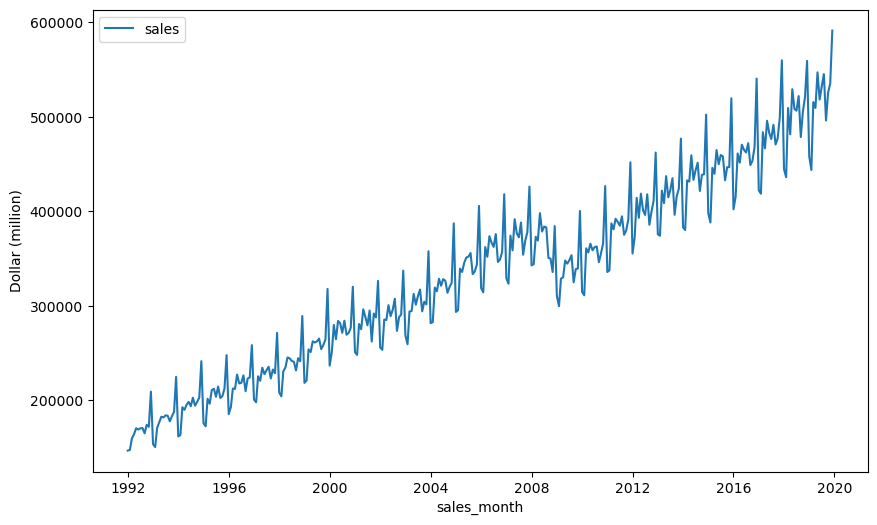

In [7]:
data_pdf.set_index('sales_month').plot(
    figsize=(10,6),
    ylabel="Dollar (million)", 
    legend=True,
    # title='Monatlicher Verlauf von "Retail and food services sales, total"'
)

#### 2

In [8]:
sql = """
SELECT date_part('year',sales_month) as sales_year
,sum(sales) as sales
FROM retail_sales
WHERE kind_of_business = 'Retail and food services sales, total'
GROUP BY 1
ORDER BY 1
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
# data_pdf

<AxesSubplot:xlabel='sales_year', ylabel='Dollar (million)'>

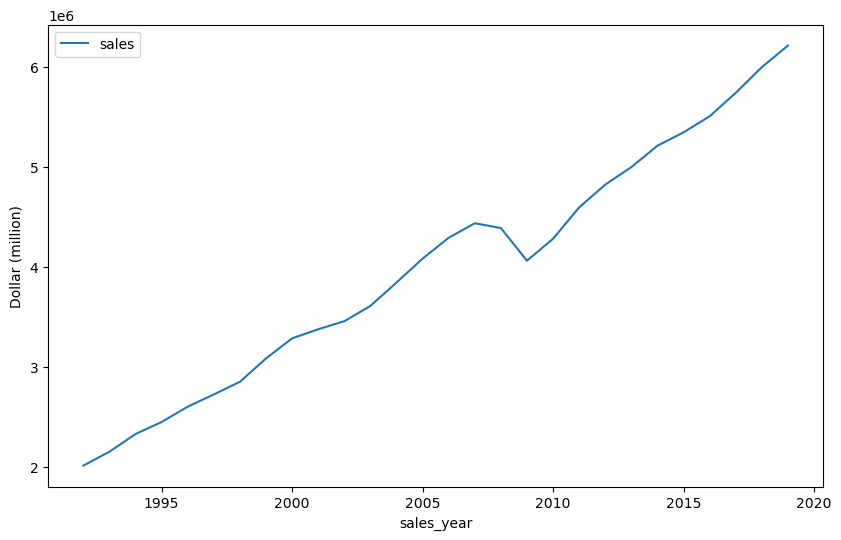

In [9]:
data_pdf.set_index('sales_year').plot(
    figsize=(10,6),
    ylabel="Dollar (million)", 
    legend=True,
    # title='Jährlicher Verlauf von "Retail and food services sales, total"'
)

#### 3

In [10]:
sql = """
SELECT date_part('year',sales_month) as sales_year
,kind_of_business
,sum(sales) as sales
FROM retail_sales
WHERE kind_of_business in ('Book stores','Sporting goods stores','Hobby, toy, and game stores')
GROUP BY 1,2
ORDER BY 1,2
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
# data_pdf

<AxesSubplot:xlabel='sales_year', ylabel='sales, Dollar (million)'>

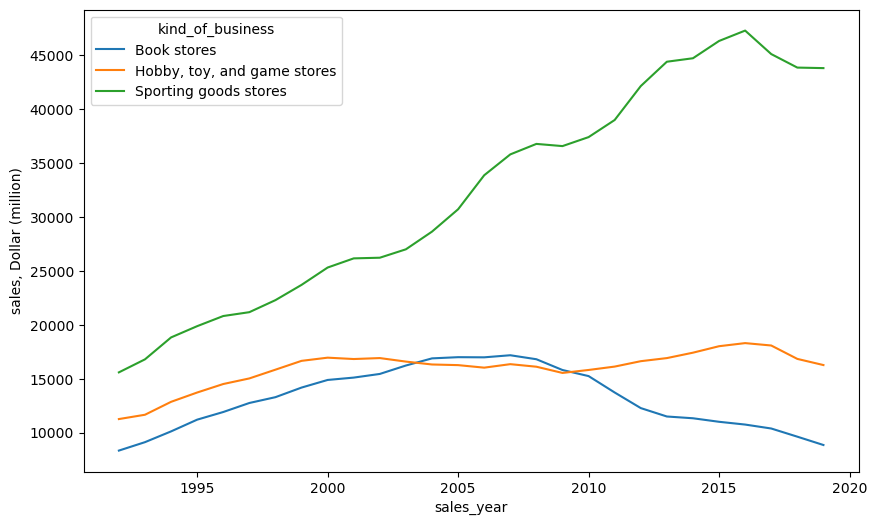

In [11]:
data_pdf.pivot(index='sales_year', columns='kind_of_business', values='sales').plot(
    figsize=(10,6),
    ylabel="sales, Dollar (million)", 
    # title='Jährlicher Verlauf von 3 ausgewählten Kategorien'
)

#### 4

In [12]:
sql = """
SELECT cast(date_part('year',sales_month) as integer) as sales_year
,kind_of_business
,sum(sales) as sales
FROM retail_sales
WHERE kind_of_business in ('Men''s clothing stores','Women''s clothing stores')
GROUP BY 1,2
order by sales_year
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
# data_pdf

<AxesSubplot:xlabel='sales_year', ylabel='sales, Dollar (million)'>

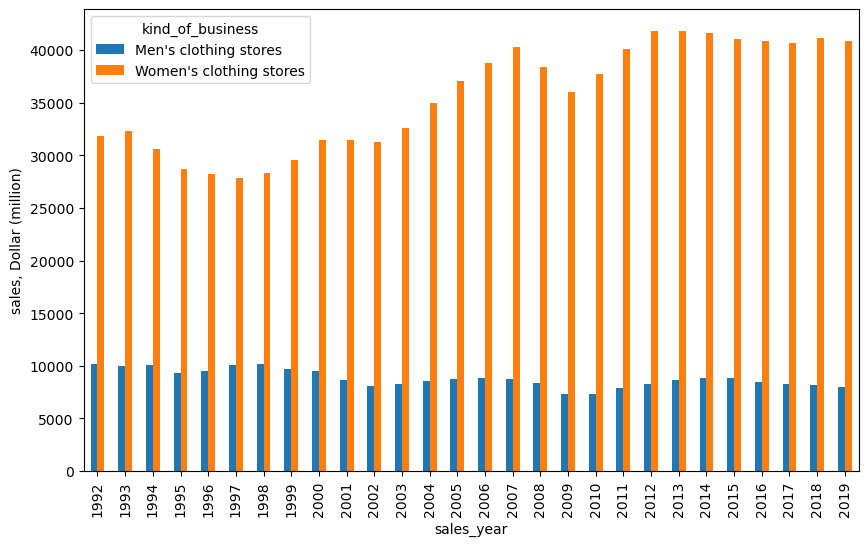

In [13]:
data_pdf.pivot(index='sales_year', columns='kind_of_business', values='sales').plot.bar(
    figsize=(10,6),
    ylabel="sales, Dollar (million)", 
    # title='Vergleich "Women\'s clothing stores" / "Man\'s clothing stores"'
)

#### 5

In [14]:
sql = """
SELECT cast(date_part('year',sales_month) as integer) as sales_year
,sum(case when kind_of_business = 'Women''s clothing stores' then sales end) 
 - sum(case when kind_of_business = 'Men''s clothing stores' then sales end) 
   as sales_diff_womens_minus_mens
FROM retail_sales
WHERE kind_of_business in ('Men''s clothing stores'
 ,'Women''s clothing stores')
GROUP BY 1
ORDER BY 1
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
# data_pdf

<AxesSubplot:xlabel='sales_year', ylabel='Dollar (million)'>

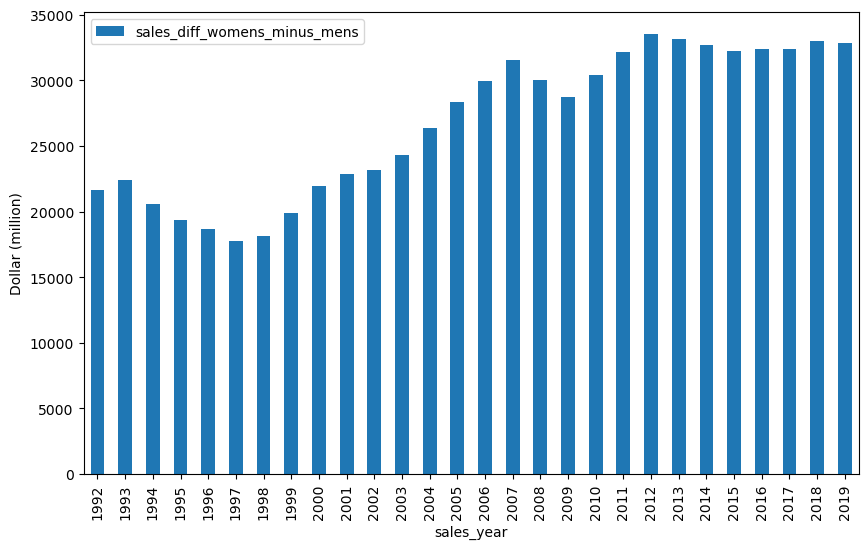

In [15]:
data_pdf.set_index('sales_year').plot.bar(
    figsize=(10,6),
    ylabel="Dollar (million)", 
    legend=True,
    # title='Differenz Sales Frauen-/Männerbekleidung'
)

#### 6

In [16]:
sql = """
with
  a as (
    select 
      cast(date_part('year', sales_month) as integer) as sales_year,
      kind_of_business,
      sum(sales) as sales
    from retail_sales
    group by 1, 2
  ),
  b as (
    select
      sales_year, 
      kind_of_business,
      sales,
      sum(sales) over(partition by sales_year) as total_sales,
      sales * 100  / sum(sales) over(partition by sales_year) as pct_total
    from a
  )
select *
from b
where kind_of_business in ('Men''s clothing stores','Women''s clothing stores')
order by sales_year
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
# data_pdf

<AxesSubplot:xlabel='sales_year', ylabel='percent'>

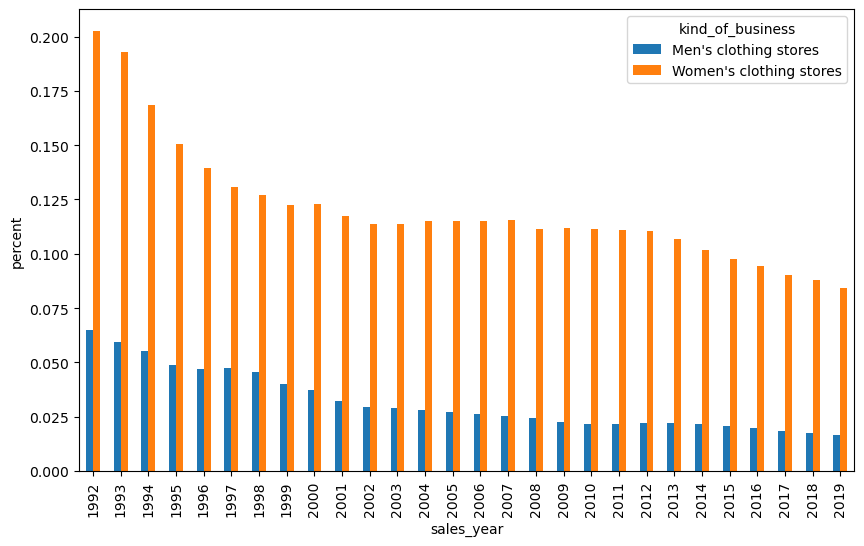

In [17]:
data_pdf.pivot(index='sales_year', columns='kind_of_business', values='pct_total').plot.bar(
    figsize=(10,6),
    ylabel="percent", 
    # stacked=True,
    # title='Prozentaler Anteil von Frauen-/Männerbekleidung pro Jahr'
)

#### 7

In [18]:
sql = """
with
  a as (
    select 
      cast(date_part('year', sales_month) as integer) as sales_year,
      kind_of_business,
      sum(sales) as sales
    from retail_sales
    where kind_of_business in ('Men''s clothing stores','Women''s clothing stores')
    group by 1, 2
  ),
  b as (
    select
      sales_year, 
      kind_of_business,
      sales,
      sum(sales) over(partition by sales_year) as total_sales,
      sales * 100  / sum(sales) over(partition by sales_year) as pct_total
    from a
  )
select *
from b
order by sales_year
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
# data_pdf

<AxesSubplot:xlabel='sales_year', ylabel='percent'>

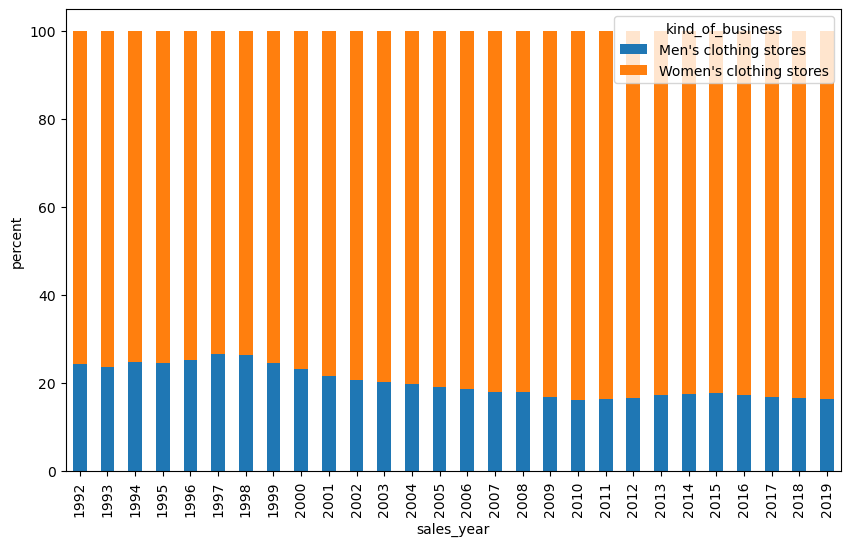

In [19]:
data_pdf.pivot(index='sales_year', columns='kind_of_business', values='pct_total').plot.bar(
    figsize=(10,6),
    ylabel="percent", 
    stacked=True,
    # title='Verhältnis prozentaler Anteil von Frauen-/Männerbekleidung pro Jahr'
)

#### 8

In [20]:
sql = """
SELECT sales_year, kind_of_business, sales
,(sales / first_value(sales) over (partition by kind_of_business order by sales_year) - 1) * 100 as pct_from_index
FROM
(
        SELECT date_part('year',sales_month) as sales_year
        ,kind_of_business
        ,sum(sales) as sales
        FROM retail_sales
        WHERE kind_of_business in ('Men''s clothing stores','Women''s clothing stores')  
        GROUP BY 1,2
) a
order by 1,2
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
# data_pdf

<AxesSubplot:xlabel='sales_year', ylabel='percent from index'>

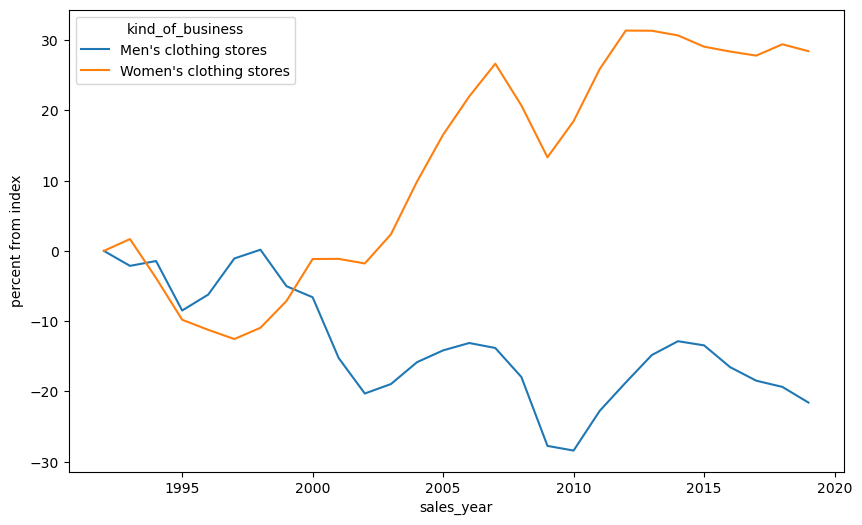

In [21]:
data_pdf.pivot(index='sales_year', columns='kind_of_business', values='pct_from_index').plot(
    figsize=(10,6),
    ylabel="percent from index", 
    # title='xxx'
)

#### 9

In [22]:
sql = """
SELECT sales_month, sales
,avg(sales) 
  over (order by sales_month rows between 11 preceding and current row) as sales_moving_avg
,count(sales) 
  over (order by sales_month rows between 11 preceding and current row) as records_count
FROM retail_sales
WHERE 
  kind_of_business = 'Women''s clothing stores'
  and sales_month <= '2019-12-31'
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
# data_pdf

<AxesSubplot:xlabel='sales_month', ylabel='Dollar (million)'>

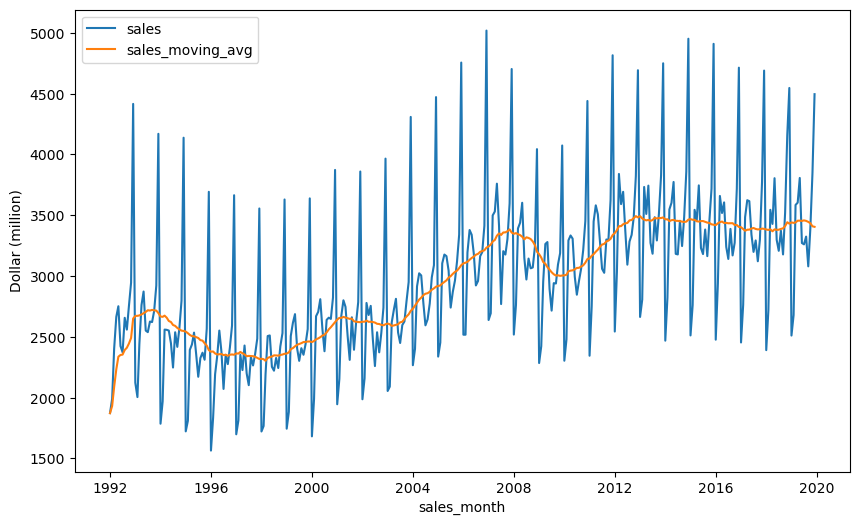

In [23]:
data_pdf.set_index('sales_month')[['sales', 'sales_moving_avg']].plot(
    figsize=(10,6),
    ylabel="Dollar (million)", 
    # title='xxx"'
)


#### 10

In [24]:
sql = """
SELECT to_char( sales_month, 'Mon') as month
,sales
,sum(sales) over (order by sales_month) as sales_ytd
FROM retail_sales
WHERE kind_of_business = 'Women''s clothing stores'
and sales_month between '2019-01-01' and '2019-12-31'
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
data_pdf

month   sales  sales_ytd
0    Jan  2511.0     2511.0
1    Feb  2680.0     5191.0
2    Mar  3585.0     8776.0
3    Apr  3604.0    12380.0
4    May  3807.0    16187.0
5    Jun  3272.0    19459.0
6    Jul  3261.0    22720.0
7    Aug  3325.0    26045.0
8    Sep  3080.0    29125.0
9    Oct  3390.0    32515.0
10   Nov  3850.0    36365.0
11   Dec  4496.0    40861.0

<AxesSubplot:xlabel='month', ylabel='Dollar (million)'>

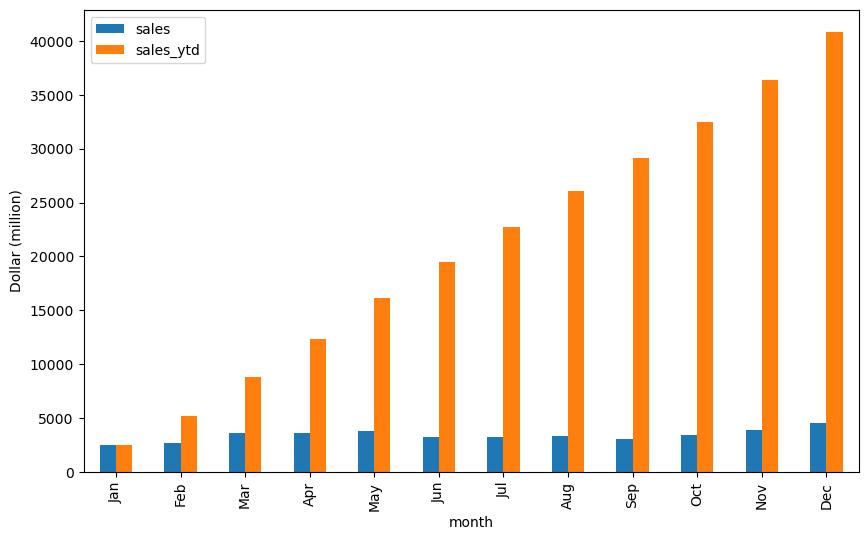

In [25]:
data_pdf.set_index('month')[['sales', 'sales_ytd']].plot.bar(
    figsize=(10,6),
    ylabel="Dollar (million)", 
    legend=True,
    # title='xxx'
)

#### 11

In [26]:
sql = """
SELECT cast(sales_year as integer), yearly_sales
,lag(yearly_sales) over (order by sales_year) 
  as prev_year_sales
,(yearly_sales / lag(yearly_sales) over (order by sales_year) -1) * 100 
  as pct_growth_from_previous_year
FROM
(
        SELECT date_part('year',sales_month) as sales_year
        ,sum(sales) as yearly_sales
        FROM retail_sales
        WHERE kind_of_business = 'Book stores'
        and sales_month <= '2019-12-31'
        GROUP BY 1
) a
order by sales_year
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
data_pdf

sales_year  yearly_sales  prev_year_sales  pct_growth_from_previous_year
0         1992        8327.0              NaN                            NaN
1         1993        9108.0           8327.0                       9.379128
2         1994       10107.0           9108.0                      10.968379
3         1995       11196.0          10107.0                      10.774711
4         1996       11905.0          11196.0                       6.332619
5         1997       12742.0          11905.0                       7.030659
6         1998       13282.0          12742.0                       4.237953
7         1999       14172.0          13282.0                       6.700798
8         2000       14879.0          14172.0                       4.988710
9         2001       15098.0          14879.0                       1.471873
10        2002       15437.0          15098.0                       2.245331
11        2003       16219.0          15437.0                       5.065751
12        2004       16881.0          16219.0                       4.081633
13        2005       16992.0          16881.0                       0.657544
14        2006       16978.0          16992.0                      -0.082392
15        2007       17171.0          16978.0                       1.136765
16        2008       16801.0          17171.0                      -2.154796
17        2009       15802.0          16801.0                      -5.946075
18        2010       15238.0          15802.0                      -3.569168
19        2011       13716.0          15238.0                      -9.988187
20        2012       12269.0          13716.0                     -10.549723
21        2013       11489.0          12269.0                      -6.357486
22        2014       11325.0          11489.0                      -1.427452
23        2015       10998.0          11325.0                      -2.887417
24        2016       10741.0          10998.0                      -2.336789
25        2017       10375.0          10741.0                      -3.407504
26        2018        9617.0          10375.0                      -7.306024
27        2019        8844.0           9617.0                      -8.037850

<AxesSubplot:xlabel='sales_year', ylabel='percent'>

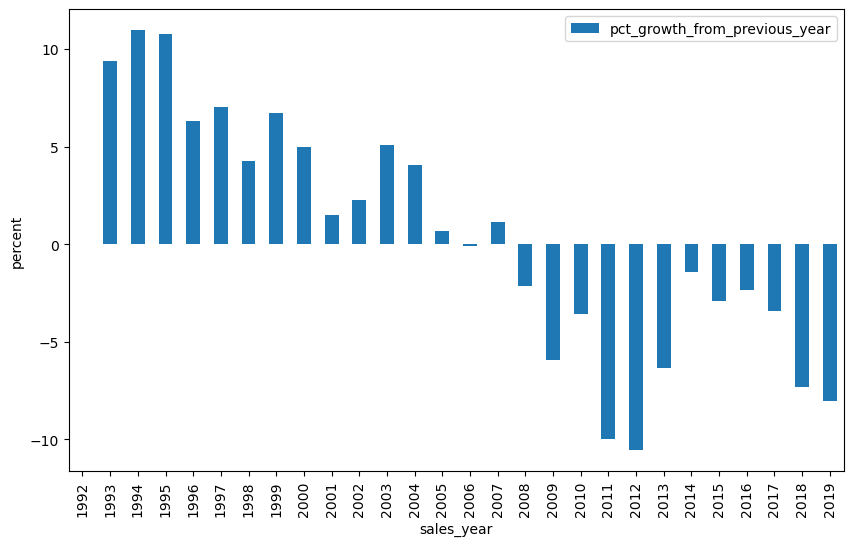

In [27]:
data_pdf.set_index('sales_year')[['pct_growth_from_previous_year']].plot.bar(
    figsize=(10,6),
    ylabel="percent", 
    legend=True,
)

#### 12

In [28]:
sql = """
SELECT date_part('month',sales_month) as month_number
,to_char(sales_month,'Month') as month_name
,max(case when date_part('year',sales_month) = 2017 then sales end) as sales_2017
,max(case when date_part('year',sales_month) = 2018 then sales end) as sales_2018
,max(case when date_part('year',sales_month) = 2019 then sales end) as sales_2019
FROM retail_sales
WHERE kind_of_business = 'Book stores' and sales_month between '2017-01-01' and '2019-12-31'
GROUP BY 1,2
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
# data_pdf

<AxesSubplot:xlabel='month_number', ylabel='dollar (million)'>

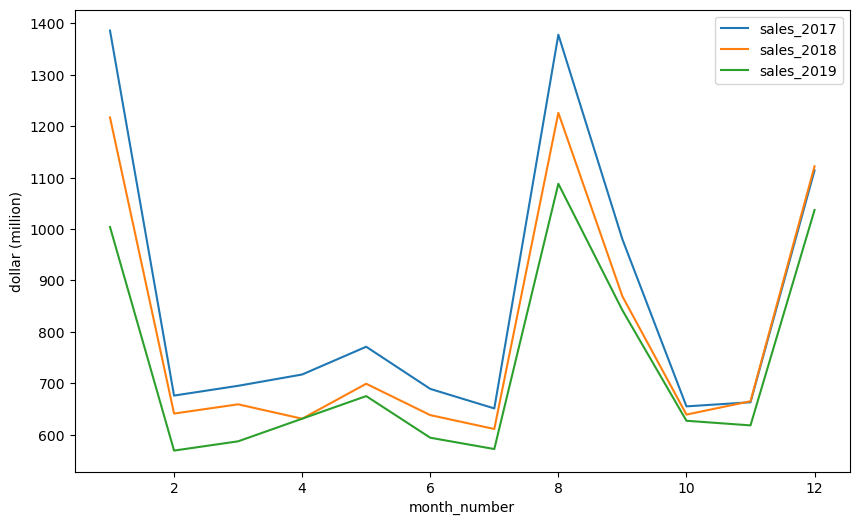

In [29]:
# data_pdf.set_index('month_name')[['sales_1992', 'sales_1993', 'sales_1994']].plot(figsize=(10,6))

data_pdf.set_index('month_number')[['sales_2017', 'sales_2018', 'sales_2019']].plot(
    figsize=(10,6),
    ylabel="dollar (million)", 
    legend=True,
)

#### 13

In [30]:
sql = """
select to_char(sales_month, 'YYYY, Mon') as month
, sales, prev_year_month, prev_year_sales, prev_year_sales_diff
from (
  SELECT sales_month
  ,sales
  ,lag(sales_month) over (partition by date_part('month',sales_month) order by sales_month) 
    as prev_year_month
  ,lag(sales) over (partition by date_part('month',sales_month) order by sales_month) 
    as prev_year_sales
  ,coalesce(sales - lag(sales) 
    over (partition by date_part('month',sales_month) order by sales_month), 0)
    as prev_year_sales_diff
  FROM retail_sales
  WHERE 
    kind_of_business = 'Book stores'
    and sales_month between '2017-01-01' and '2019-12-31'
) a
where sales_month >= '2018-01-01'
order by 3
;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
# data_pdf

<AxesSubplot:xlabel='month', ylabel='Dollar (million)'>

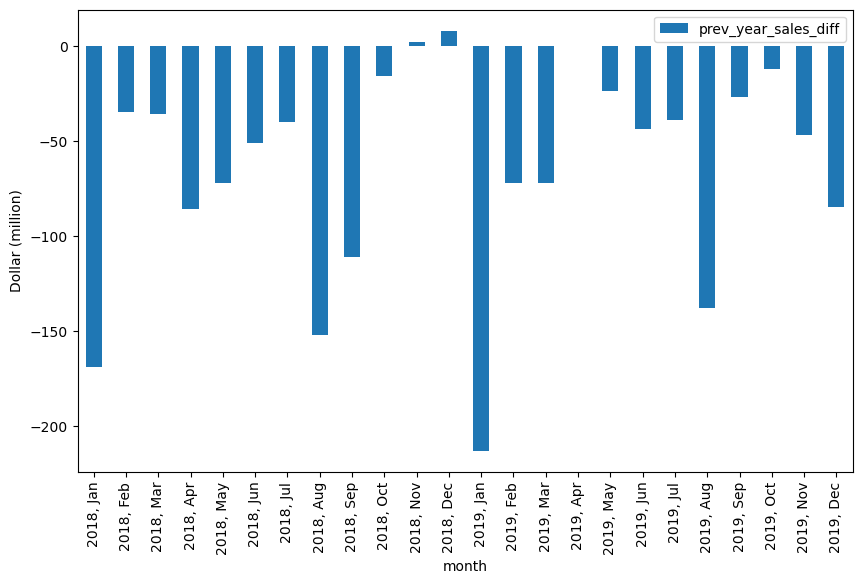

In [31]:
data_pdf.set_index('month')[['prev_year_sales_diff']].plot.bar(
    figsize=(10,6),
    ylabel="Dollar (million)", 
    legend=True,
)